##### This project is for univariate time series analysis, using one feature to predict the prices of the financial markets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.layers import SimpleRNN
import yfinance as yahooFinance
from keras.utils import timeseries_dataset_from_array
import tensorflow as tf
import datetime

##### Load the Dataset and preprocess it

In [2]:
df = pd.read_csv('BTC-sep-2023-2024.csv', parse_dates=["Date"])
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2023-09-21 00:00:00+00:00,27129.839844,27152.939453,26389.300781,26567.632812,13371443708,0.0,0.0
1,2023-09-22 00:00:00+00:00,26564.056641,26726.078125,26495.533203,26579.568359,10578746709,0.0,0.0
2,2023-09-23 00:00:00+00:00,26578.556641,26634.185547,26520.519531,26579.390625,7404700301,0.0,0.0
3,2023-09-24 00:00:00+00:00,26579.373047,26716.058594,26221.050781,26256.826172,8192867686,0.0,0.0
4,2023-09-25 00:00:00+00:00,26253.775391,26421.507812,26011.468750,26298.480469,11997833257,0.0,0.0
...,...,...,...,...,...,...,...,...
360,2024-09-15 00:00:00+00:00,60000.726562,60381.917969,58696.308594,59182.835938,18120960867,0.0,0.0
361,2024-09-16 00:00:00+00:00,59185.226562,59205.511719,57501.339844,58192.507812,32032822113,0.0,0.0
362,2024-09-17 00:00:00+00:00,58192.507812,61316.089844,57628.070312,60308.539062,38075570118,0.0,0.0
363,2024-09-18 00:00:00+00:00,60309.000000,61664.066406,59218.253906,61649.679688,40990702891,0.0,0.0


In [3]:
df['Date'] = pd.to_datetime(df['Date']).dt.date

In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [5]:
df2 = df.sort_values("Date").set_index("Date")
df2

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-09-21,27129.839844,27152.939453,26389.300781,26567.632812,13371443708,0.0,0.0
2023-09-22,26564.056641,26726.078125,26495.533203,26579.568359,10578746709,0.0,0.0
2023-09-23,26578.556641,26634.185547,26520.519531,26579.390625,7404700301,0.0,0.0
2023-09-24,26579.373047,26716.058594,26221.050781,26256.826172,8192867686,0.0,0.0
2023-09-25,26253.775391,26421.507812,26011.468750,26298.480469,11997833257,0.0,0.0
...,...,...,...,...,...,...,...
2024-09-15,60000.726562,60381.917969,58696.308594,59182.835938,18120960867,0.0,0.0
2024-09-16,59185.226562,59205.511719,57501.339844,58192.507812,32032822113,0.0,0.0
2024-09-17,58192.507812,61316.089844,57628.070312,60308.539062,38075570118,0.0,0.0


In [6]:
df3 = df2.drop(['Dividends', 'Stock Splits'], axis='columns')
df3

,Open,High,Low,Close,Volume
Date,,,,,
2023-09-21,27129.839844,27152.939453,26389.300781,26567.632812,13371443708
2023-09-22,26564.056641,26726.078125,26495.533203,26579.568359,10578746709
2023-09-23,26578.556641,26634.185547,26520.519531,26579.390625,7404700301
2023-09-24,26579.373047,26716.058594,26221.050781,26256.826172,8192867686
2023-09-25,26253.775391,26421.507812,26011.468750,26298.480469,11997833257
...,...,...,...,...,...
2024-09-15,60000.726562,60381.917969,58696.308594,59182.835938,18120960867
2024-09-16,59185.226562,59205.511719,57501.339844,58192.507812,32032822113
2024-09-17,58192.507812,61316.089844,57628.070312,60308.539062,38075570118


##### Visualizing the dataset

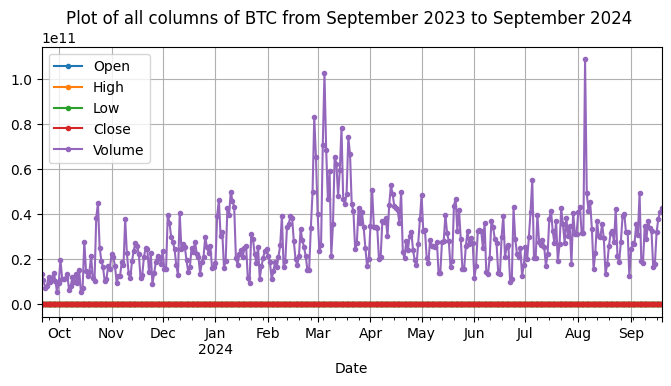

In [7]:
df3["2023-09":"2024-09"].plot(grid=True, marker=".", figsize=(8,3.5))
plt.title('Plot of all columns of BTC from September 2023 to September 2024 ')
plt.show()

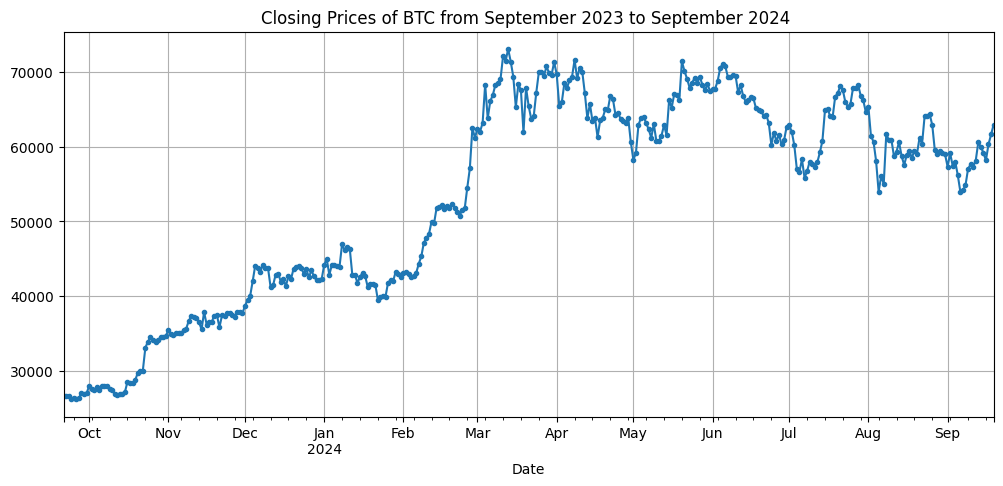

In [8]:
close = df3['Close']
close["2023-09":"2024-09"].plot(grid=True, marker=".", figsize=(12,5))
plt.title('Closing Prices of BTC from September 2023 to September 2024 ')
plt.show()

##### Splitting the Dataset into Training, Validation and Test Dataset

In [9]:
train_data = close["2023-09":"2024-7-26"] / 1e6
valid_data = close["2024-07-27":"2024-08"] / 1e6
test_data = close["2024-09"] / 1e6

In [10]:
len(train_data)

310

In [11]:
36+310

346

In [12]:
seq_length = 20

In [13]:
train_ds = keras.utils.timeseries_dataset_from_array(
 train_data.to_numpy(),
 targets=train_data[seq_length:],
 sequence_length=seq_length,
 batch_size=32,
 shuffle=True,
 seed=42
)

In [14]:
valid_ds = keras.utils.timeseries_dataset_from_array(
 valid_data.to_numpy(),
 targets=valid_data[seq_length:],
 sequence_length=seq_length,
 batch_size=32
)

##### Model Building and Training

In [15]:
tf.random.set_seed(42)

In [16]:
model = keras.Sequential([
 keras.layers.LSTM(21, return_sequences=True, input_shape=[None, 1]),
 keras.layers.LSTM(40, return_sequences=True),
 keras.layers.LSTM(15),
 keras.layers.Dropout(0.2),
 keras.layers.Dense(1)
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 21)          1932      
                                                                 
 lstm_1 (LSTM)               (None, None, 40)          9920      
                                                                 
 lstm_2 (LSTM)               (None, 15)                3360      
                                                                 
 dropout (Dropout)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 15228 (59.48 KB)
Trainable params: 15228 (59.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
opt = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=keras.losses.Huber(), optimizer=opt,metrics=["mae"])

In [19]:
history = model.fit(train_ds, validation_data=valid_ds,epochs=100,callbacks=[early_stopping_cb])

Epoch 1/100


10/10 [==============================] - 32s 589ms/step - loss: 5.2746e-04 - mae: 0.0276 - val_loss: 1.7432e-04 - val_mae: 0.0186
Epoch 2/100
10/10 [==============================] - 1s 52ms/step - loss: 2.6232e-04 - mae: 0.0189 - val_loss: 2.9477e-04 - val_mae: 0.0242
Epoch 3/100
10/10 [==============================] - 1s 45ms/step - loss: 1.5794e-04 - mae: 0.0144 - val_loss: 3.2597e-06 - val_mae: 0.0024
Epoch 4/100
10/10 [==============================] - 1s 67ms/step - loss: 1.2159e-04 - mae: 0.0127 - val_loss: 7.8369e-05 - val_mae: 0.0123
Epoch 5/100
10/10 [==============================] - 0s 42ms/step - loss: 9.8465e-05 - mae: 0.0118 - val_loss: 7.7926e-06 - val_mae: 0.0034
Epoch 6/100
10/10 [==============================] - 1s 45ms/step - loss: 1.0020e-04 - mae: 0.0121 - val_loss: 3.6159e-05 - val_mae: 0.0082
Epoch 7/100
10/10 [==============================] - 1s 44ms/step - loss: 8.9864e-05 - mae: 0.0118 - val_loss: 3.2486e-05 - val_mae: 0.0078
Epoch 8/100
10/1

In [20]:
model.save('univar_deep_v1_1.h5')

c:\Users\TeeFaith\anaconda3\envs\kenny\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##### Make Predictions to see Models Performance

In [21]:
X = valid_data.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(16):
    y_pred_one = model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 40ms/step


In [22]:
pred = X.reshape(-1,1) * 1e6

In [23]:
col = ['Predicted']

In [24]:
pred_df = pd.DataFrame(pred, columns=col)
pred_df.shape

(36, 1)

In [25]:
valid_data = pd.DataFrame(close["2024-07-27":"2024-08"]).reset_index()
valid_data.shape

(36, 2)

In [26]:
concat_df = pd.concat([valid_data, pred_df], axis='columns')
concat_df

,Date,Close,Predicted
0,2024-07-27,67813.335938,67813.335938
1,2024-07-28,68255.867188,68255.867188
2,2024-07-29,66819.914062,66819.914062
3,2024-07-30,66201.015625,66201.015625
4,2024-07-31,64619.250000,64619.250000
5,2024-08-01,65357.500000,65357.500000
6,2024-08-02,61415.066406,61415.066406
7,2024-08-03,60680.093750,60680.093750
8,2024-08-04,58116.976562,58116.976562
9,2024-08-05,53991.457031,53991.457031


In [27]:
concat_df2 = concat_df.sort_values("Date").set_index("Date")
concat_df2

,Close,Predicted
Date,,
2024-07-27,67813.335938,67813.335938
2024-07-28,68255.867188,68255.867188
2024-07-29,66819.914062,66819.914062
2024-07-30,66201.015625,66201.015625
2024-07-31,64619.250000,64619.250000
2024-08-01,65357.500000,65357.500000
2024-08-02,61415.066406,61415.066406
2024-08-03,60680.093750,60680.093750
2024-08-04,58116.976562,58116.976562


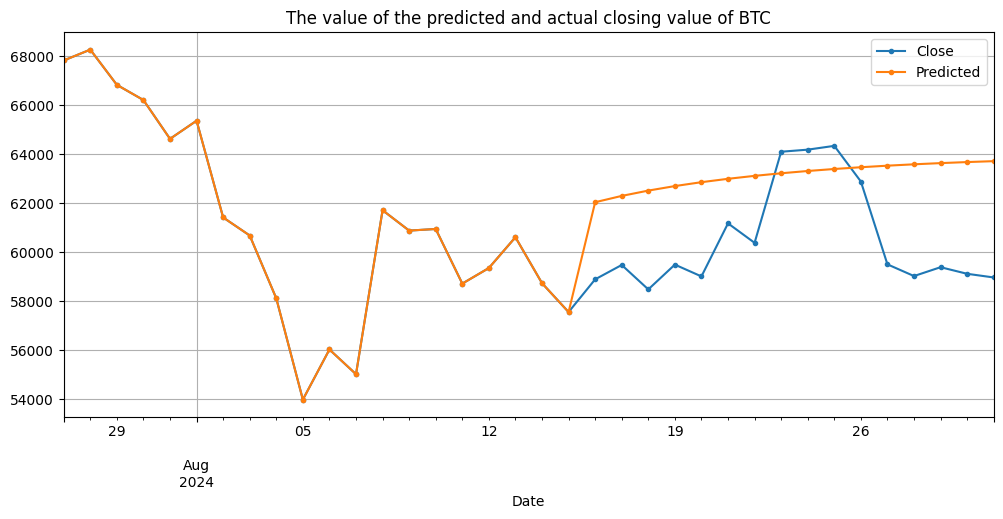

In [28]:
concat_df2['2024-07':'2024-08'].plot(grid=True, marker=".", figsize=(12,5))
plt.title('The value of the predicted and actual closing value of BTC')
plt.show()